<a href="https://colab.research.google.com/github/plaban1981/Dphi_hackathon/blob/main/Data_Sprint_25_Flower_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement  **Build a model to recognize the name of a flower**

## Download the images

In [1]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1H0rJmSBmYQoWM2w2tqy-jmX0Y2Wg6k2v',
dest_path='content/flowers.zip',
unzip=True)

Unzipping...Done.


## Loading Libraries

In [3]:
import pandas as pd # Data analysis and manipultion tool
import numpy as np # Fundamental package for linear algebra and multidimensional arrays
import tensorflow as tf # Deep Learning Tool
import os # OS module in Python provides a way of using operating system dependent functionality
import cv2 # Library for image processing
from sklearn.model_selection import train_test_split # For splitting the data into train and validation set
from sklearn.metrics import accuracy_score

#
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import glob
from pathlib import Path
from fastai import *
from fastai.vision import *
import torch
from fastai.callbacks.hooks import *
import warnings
warnings.filterwarnings('ignore')

In [4]:
test = pd.read_csv("/content/content/flowers/Testing_set_flower.csv")
test.head()

,filename
0,Image_1.jpg
1,Image_2.jpg
2,Image_3.jpg
3,Image_4.jpg
4,Image_5.jpg


In [5]:
sub = pd.read_csv("/content/content/flowers/sample_submission.csv")
sub.head()

,prediction
0,sunflower
1,sunflower
2,sunflower
3,sunflower
4,sunflower


In [20]:
import os
filename = []
label = []
for folder in os.listdir("/content/content/flowers/train"):
  folder_name = "/content/content/flowers/train/"+ folder
  for image in os.listdir(folder_name):
    filename.append(folder+"/"+image)
    label.append(folder)

In [21]:
train = pd.DataFrame({'filename':filename,'label':label})
train.head()

,filename,label
0,dandelion/15644450971_6a28298454_n.jpg,dandelion
1,dandelion/8723679596_391a724d4f_m.jpg,dandelion
2,dandelion/5608832856_f5d49de778.jpg,dandelion
3,dandelion/9939430464_5f5861ebab.jpg,dandelion
4,dandelion/3856725141_0db85f466d_n.jpg,dandelion


In [11]:
train.shape

(2746, 2)

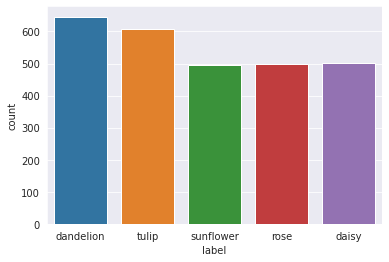

In [16]:
import seaborn as sns
sns.set_style('darkgrid')
sns.countplot(train['label'])

In [23]:
train.to_csv("/content/content/flowers/train.csv",index=False)

In [24]:
path= '/content/content/flowers/train'
tfms = get_transforms(flip_vert=False,max_zoom=1.0,max_warp=0,do_flip=False,xtra_tfms=[cutout()])
data = (ImageList.from_csv(path, csv_name = '/content/content/flowers/train.csv')
        .split_by_rand_pct()              
        .label_from_df()            
        .add_test_folder(test_folder = '/content/content/flowers/test')              
        .transform(tfms, size=224)
        .databunch(num_workers=0,bs=8))

In [25]:
val=data.classes
print(val)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


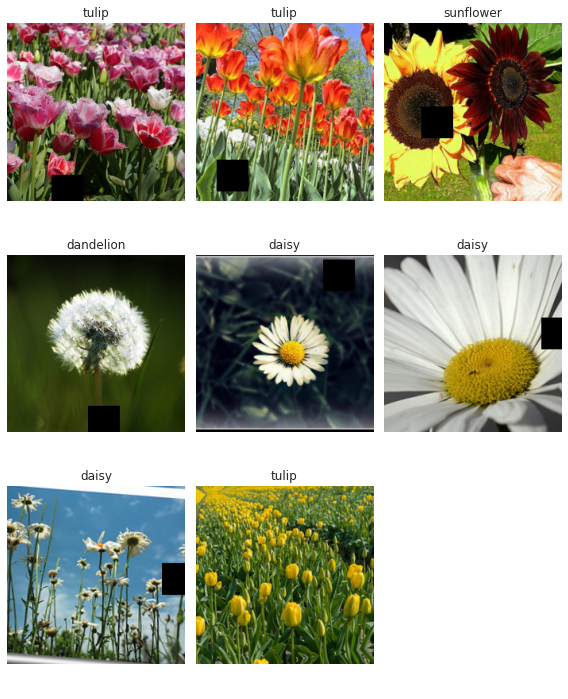

In [26]:
## to see the images in train with there labels
data.show_batch(rows=3, figsize=(8,10))

In [27]:
print(data.classes)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [36]:
path= '/content/content/flowers/train'
k= '/content/content/flowers/train.csv'
p ='/content/content/flowers/Testing_set_flower.csv'

In [30]:
learn = cnn_learner(data, models.densenet121, metrics=[error_rate, accuracy], model_dir="/tmp/model/")

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


In [31]:
from fastai import *
from fastai.vision import *
from sklearn.model_selection import StratifiedKFold
from pathlib import Path
import shutil
from sklearn.metrics import f1_score, confusion_matrix

np.random.seed(1786)
ROOT = "/content/content/flowers"

In [32]:
def read_data(root):
    train_df = pd.read_csv(k)
    test_df = pd.read_csv(p)
    return train_df, test_df

In [33]:
class SaveBestModel(Recorder):
    def __init__(self, learn,name='best_model'):
        super().__init__(learn)
        self.name = name
        self.best_loss = None
        self.best_acc = None
        self.save_method = self.save_when_acc
        
    def save_when_acc(self, metrics):        
        loss, acc = metrics[0], metrics[1]
        if (self.best_acc is None) or (acc > self.best_acc) or (loss < self.best_loss):
            self.best_acc = acc
            self.best_loss = loss
            self.learn.save(f'{self.name}')
            print("Save the best acc {:.5f}".format(self.best_acc))
        elif acc == self.best_acc and  loss < self.best_loss:
            self.best_loss = loss
            self.learn.save(f'{self.name}')
            print("Acc is eq,Save the lower loss {:.5f}".format(self.best_loss))
            
    def on_epoch_end(self,last_metrics=MetricsList,**kwargs:Any):
        self.save_method(last_metrics)

In [39]:
if __name__=="__main__":
    train_df, test_df = read_data(ROOT)
    print(train_df.shape, test_df.shape)
    
    cvlist = list(StratifiedKFold(16, random_state=12345786).split(train_df, train_df.label))
    
    tfms1 = get_transforms(max_zoom=2.0)
    test_preds_all = []
    val_preds_all = []
    for i in range(2):
        print("Starting fold {}".format(i))
        tr_idx, val_idx = cvlist[i]
        print(tr_idx.shape, val_idx.shape)
        src = (ImageList.from_df(train_df, path=ROOT, folder="train").split_by_idxs(tr_idx, val_idx)
                                                            .label_from_df())
        data = ImageDataBunch.create_from_ll(src, ds_tfms=tfms1, size=224, bs=32, resize_method=3).normalize(imagenet_stats)
        data.add_test(ImageList.from_df(test_df, path=ROOT, folder="test"))
        learn = cnn_learner(data, models.densenet121, metrics=accuracy, ps=0.5)
        # learn.model[0].load_state_dict(torch.load("../input/save-body-weights-marvel/bestmodel_body.path"))
        cb = SaveBestModel(learn, name="bestmodel_{}".format(i))
        # learn.fit(1, callbacks=cb)
        learn.fit_one_cycle(4)
        learn.unfreeze()
        learn.fit_one_cycle(3, max_lr=1e-4, callbacks=[cb])
        learn.fit_one_cycle(2, max_lr=5e-5, callbacks=[cb])
        learn.fit_one_cycle(1, max_lr=1e-5, callbacks=[cb])
        learn.fit_one_cycle(1, max_lr=5e-6, callbacks=[cb])
        learn.fit_one_cycle(2, max_lr=1e-6, callbacks=[cb])
        learn.load("bestmodel_{}".format(i))
        val_preds, y = learn.TTA(ds_type=DatasetType.Valid)
        val_preds = np.exp(val_preds.numpy())
        print("F1 score for this fold ",f1_score(y.numpy(), np.argmax(val_preds,axis=1), average='weighted'))
        test_preds = np.exp(learn.TTA(ds_type=DatasetType.Test)[0].numpy())
        test_preds_all.append(test_preds)
        val_preds_all.append(val_preds)
        fname = "bestmodel_{}.pth".format(i)
        src = str(Path(ROOT) / "models" / fname)
        shutil.copy(src, fname)
    test_preds_all = np.mean(test_preds_all, axis=0)
    val_preds_all = np.concatenate(val_preds_all, axis=0)

    np.save("test_preds.npy", test_preds_all)
    np.save("val_preds.npy", val_preds_all)


(2746, 2) (924, 1)
Starting fold 0
(2574,) (172,)


epoch,train_loss,valid_loss,accuracy,time
0,0.761025,0.362056,0.860465,00:26
1,0.501585,0.270549,0.924419,00:26
2,0.345595,0.197820,0.906977,00:26
3,0.249455,0.188440,0.906977,00:26


epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.216031,0.140202,0.941860,00:27
1,0.201624,0.122593,0.959302,00:27
2,0.139076,0.119749,0.959302,00:27


Save the best acc 0.94186
Save the best acc 0.95930
Save the best acc 0.95930


epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.122653,0.098184,0.965116,00:28
1,0.109783,0.112798,0.959302,00:28


Save the best acc 0.96512


epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.094443,0.108152,0.953488,00:28


epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.104601,0.116376,0.959302,00:27


epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.106342,0.108838,0.953488,00:28
1,0.092973,0.095452,0.953488,00:27


Save the best acc 0.95349


F1 score for this fold  0.9591420380795188


Starting fold 1
(2574,) (172,)


epoch,train_loss,valid_loss,accuracy,time
0,0.738155,0.379586,0.901163,00:26
1,0.486670,0.280197,0.895349,00:26
2,0.335552,0.214680,0.918605,00:26
3,0.243596,0.190668,0.936047,00:26


epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.198593,0.314904,0.918605,00:28
1,0.198931,0.235812,0.936047,00:28
2,0.156409,0.236555,0.936047,00:27


Save the best acc 0.91860
Save the best acc 0.93605


epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.129572,0.215322,0.941860,00:28
1,0.111501,0.249405,0.930233,00:28


Save the best acc 0.94186


epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.091367,0.235516,0.930233,00:28


epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.090975,0.223527,0.936047,00:28


epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.092274,0.233206,0.941860,00:28
1,0.090336,0.226413,0.936047,00:28


F1 score for this fold  0.9414518871883213


In [40]:
x = np.argmax(test_preds, axis=1)
x

array([3, 3, 1, 2, ..., 1, 1, 1, 0])

In [41]:
val

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [42]:
f=[]
for i in x:
  f.append(val[i])

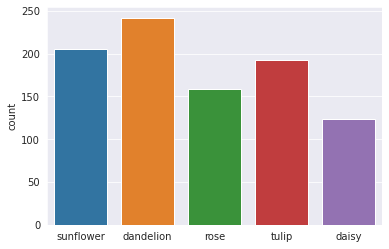

In [43]:
sns.countplot(f)

## Save Predictions

In [45]:
res = pd.DataFrame({'filename': test['filename'], 'prediction': f}) # prediction is nothing but the final predictions of your model on input features of your new unseen test data
res[['prediction']].to_csv("submission_dphi25.csv", index = False) # the csv file will be saved locally on the same location where this notebook is located.

**densenet121 submission scores : 94.37229437229438**